<img src = "https://github.com/barcelonagse-datascience/academic_files/raw/master/bgsedsc_0.jpg">
$\newcommand{\bb}{\boldsymbol{\beta}}$
$\DeclareMathOperator{\Gau}{\mathcal{N}}$
$\newcommand{\bphi}{\boldsymbol \phi}$
$\newcommand{\bpi}{\boldsymbol \pi}$
$\newcommand{\bx}{\boldsymbol{x}}$
$\newcommand{\by}{\boldsymbol{y}}$
$\newcommand{\bmu}{\boldsymbol{\mu}}$
$\newcommand{\bS}{\boldsymbol{\Sigma}}$
$\newcommand{\whbb}{\widehat{\bb}}$
$\newcommand{\hf}{\hat{f}}$
$\newcommand{\hy}{\hat{y}}$
$\newcommand{\tf}{\tilde{f}}$
$\newcommand{\ybar}{\overline{y}}$
$\newcommand{\E}{\mathbb{E}}$
$\newcommand{\Var}{Var}$
$\newcommand{\Cov}{Cov}$
$\newcommand{\Cor}{Cor}$

# Project: Linear Classification

## Programming project: forest cover classification

In this project, you have to predict the class of forest cover (the predominant kind of tree cover) from strictly cartographic and environment variables.

The actual forest cover type for a given observation (30 x 30 meter cell) was determined from US Forest Service (USFS) Region 2 Resource Information System (RIS) data. Independent variables were derived from data originally obtained from US Geological Survey (USGS) and USFS data. Data is in raw form (not scaled) and contains categorical data for qualitative independent variables (wilderness areas and soil types).

You have further details on the data at *covertype.info* file and at https://archive.ics.uci.edu/ml/datasets/Covertype

Be aware that the final dataset has been slighly modified from the original source data.

As performance metric, you can use *AUC* in the binary classification case. For multi-class classification, check as well the confussion matrix and estimate the misclassification probabilities of different classes(check *metrics.confusion_matrix* and *metrics.classification_report* in *sklearn*).

+ Using *MultiClass_Train.csv* file build a predictive model for *Cover_Type* .
+ Try a first a binary classification to predict class #7 (Krummholz, https://en.wikipedia.org/wiki/Krummholz), which is a rare valuable habitat. After that, then try multi-variate classification to predict all classes.
+ For this analysis there is an extra test dataset. Once your code is submitted we will run a competition to see how you score in the test data. Hence have prepared also the necessary script to compute the accuracy estimate on the test data once released.

You can follow those **steps** in your first implementation:
1. *Explore* and understand the dataset. 
2. Create *dummy variables* for relevant categorical features
3. Reformat the Class_type variable into a binary one, being class #7 the target variable versus the others.
4. *Build* an initial binary model for class #7 versus the other ones and test it on the same input data. 
5. Assess expected accuracy using *cross-validation*
6. Report which variable impacts more on results 
7. Try to improve it using methods to tackle class imbalance.
8. Repeat 4., 5., 6. and 7. now with a multi-class model (EXTENDED PROJECT)
9. Produce .csv for kaggle testing 


## Main criteria for grading
From more to less important (the weighting of these components will vary between the in-class and extended projects):
+ Code runs
+ Data preparation
+ Logistic Regression Models(s) have been used
+ Cover Type prediction made
+ Accuracy of predictions for test set (kaggle)
+ Class imbalance management
+ Hyperparameter optimization

In [193]:
# Libraries and functions to be used 
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy.stats import skew 
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from scipy.stats import chi2_contingency, ttest_ind
plt.style.use('ggplot')
import itertools
import warnings
warnings.filterwarnings('ignore')

In [215]:
# Created functions and classes

# For contengency tables
class Contengency_Table:
    def __init__(self, df, outcome, var):
        self.cont_table = pd.crosstab(df[var], df[outcome], margins=True)
        self._var = var
    def chi_squared_test(self):
        chi2, p, dof, ex = chi2_contingency(self.cont_table)
        print(self._var,': p-value of chisquare test =', p)
    def barplot(self):
        sns.set_theme(style="whitegrid")
        k=pd.melt(ct.cont_table.drop("All", axis=0).reset_index().drop("All", axis = 1), id_vars = [var])
        k[var] = k[var].astype("category")
        return sns.barplot(x=var, y = "value", hue=outcome, data=k)   

    
# For ROC-AUC

def roc_auc_plot(pred_probs, y_true):
    sns.set_theme(style="whitegrid")
    fpr, tpr, _ = roc_curve(y_true, pred_probs)  #compute FPR/TPR
    auc_baseline = auc(fpr, tpr) # compute AUC
    plt.subplots(figsize=(10, 6))
    plt.plot(fpr, tpr, "b-", label="ROC Curve (AUC={:2.2f})".format(auc_baseline))
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(fontsize=15)
    plt.plot([0,1], [0,1], "r--")
    plt.title("ROC curve")

    
# For confussion matrix
import itertools



def plot_cf_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
    
# For Violin Plots

def Mult_Violin_Plot(data, outcome, varlist):
    sns.set_theme(style="whitegrid")
    # Iterate over variables in a list and create scatterplots for numerical variables and violinplots for categorical 
    plt.figure(figsize=(17,20))
    for i, var in enumerate(varlist):
        plt.subplot(5, 2, i+1)
        sns.violinplot(x = outcome, y = var, data = data)
        plt.title("Violin Plot of " +  outcome + " vs. " + var)
    
    return plt.tight_layout()

# For reweighting 
def reweight_multiclass(classes, probs, rj):
    q = (classes.value_counts()/classes.value_counts().sum()).sort_index()
    q.index = range(1, len(q)+1)
    reweighted_probs = []
    for pi in probs:
        tot = 0
        for j in range(1,len(q)+1):
            tot = tot + pi[j-1]*(q[j]/rj)
        probs_rew_row = []
        for i in range(1,len(q)+1):
            w = (pi[i-1]*(q[i]/rj))/tot
            probs_rew_row.append(w)
        reweighted_probs.append(probs_rew_row)
    return np.array(reweighted_probs)



    
def reweight(pi,q1=0.5,r1=0.5):
    r0 = 1-r1
    q0 = 1-q1
    tot = pi*(q1/r1)+(1-pi)*(q0/r0)
    w = pi*(q1/r1)
    w /= tot
    return w

## Introduction

The dataset of this project contains information about features of forested areas. In the training dataset we have 14 columns and 61,006 rows, while in the testing dataset there are 13073 rows and 13 columns (since this dataset does not have the variable to predict `Cover_Type`). Each observation in these datasets represents a 30 x 30 meter forest cover cell and each column characterizes it. In the following table we can see the name, type of variable, measurement unit and description of each column in the dataset. 

| Variable Name | Data Type | Measurement | Description |
|:--------------------:|:----------------------------------------------------------:|:------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------:|:-------------------------------------------------------------:|
| Elevation | quantitative | meters | Elevation in meters |
|Aspect | quantitative | azimuth | Aspect in degrees azimuth |
| Slope | quantitative | degrees | Slope in degrees |
| Horiz_dist_hydro | quantitative | meters | Horizontal Distance to nearest surface water features|
| Vertical_dist_hydro | quantitative | meters | Vertical Distance to nearest surface water features|
| Horiz_dist_roadways | quantitative | meters | Horz Dist to nearest roadway|
| Hillshade_9am | quantitative | 0 to 255 index | Hillshade index at 9am, summer solstice|
| Hillshade_Noon | quantitative | 0 to 255 index | Hillshade index at noon, summer soltice|
| Hillshade_3pm | quantitative | 0 to 255 index | Hillshade index at 3pm, summer solstice|
| Horiz_dist_firepoints | quantitative | meters | Horz Dist to nearest wildfire ignition points |
| Wilderness_Area (4 binary columns) | qualitative | 0 (absence) or 1 (presence) | Wilderness area designation |
| Soil_Type (40 binary columns) | qualitative | 0 (absence) or 1 (presence) | Soil Type designation|
| Cover_Type (7 types) | integer | 1 to 7 | Forest Cover Type designation|

In this case, we are interested in predicting the class of forest cover. As a first approach, it will be predicted class #7 (Krummholz) vs all the other classes. Secondly, the prediction will be focused on the multivariate classification to predict all cover type classes. In order to do so, we will proceed as follows:

1. Read data, drop irrelevant columns and define outcome variables
2. Exploratory Data Analysis
3. Features Transformation (Dummy and Polinomials Creation, Standardization)
4. Modelling
  - Binary Models
  - Multinomial Models

## Step 1: Read and explore data

### Read Data

Let's start by taking a look at the data, for this we read the following files `MultiClass_Train.csv` and `MultiClass_test.csv`.

In [195]:
# Reading data
df_train = pd.read_csv("Data/MultiClass_Train.csv")
df_test = pd.read_csv("Data/MultiClass_test.csv")

In [196]:
# Print df_train
df_train

,Index,Elevation,Aspect,Slope,Horiz_dist_hydro,Vertical_dist_hydro,Horiz_dist_roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horiz_dist_firepoints,Cover_Type,Wilderness_Area,Soil_Type
0,0,3202,34,10,0,0,2760,219,218,134,1734,1,3,38
1,1,3113,251,13,192,40,5600,191,249,195,2555,2,1,22
2,2,2801,77,9,510,17,1728,232,223,122,1087,2,1,12
3,3,3165,82,9,319,56,4890,233,225,124,1452,1,1,29
4,4,3048,333,11,124,31,2823,196,226,170,666,1,1,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61001,61001,3255,1,13,0,0,1552,201,215,151,713,1,1,38
61002,61002,3170,170,25,417,61,2605,229,241,128,3350,2,3,33
61003,61003,2994,170,13,134,18,1610,229,245,146,2394,2,3,33
61004,61004,2543,135,4,124,17,524,227,238,145,1106,3,4,6


In [197]:
# Print df_test 
df_test

,Index,Elevation,Aspect,Slope,Horiz_dist_hydro,Vertical_dist_hydro,Horiz_dist_roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horiz_dist_firepoints,Wilderness_Area,Soil_Type
0,61006,3111,72,13,283,76,630,235,214,109,499,3,31
1,61007,2768,0,20,134,26,912,186,198,146,1974,3,10
2,61008,3360,272,13,685,178,4502,185,244,198,2642,3,39
3,61009,2413,0,3,201,18,560,215,233,156,866,3,2
4,61010,2815,54,11,42,9,2313,226,217,123,2866,1,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13068,74074,3053,181,12,150,-13,2162,224,248,155,3827,1,23
13069,74075,2940,218,27,30,4,1433,179,253,197,2616,3,13
13070,74076,3014,208,4,283,37,4716,217,243,162,108,1,29
13071,74077,2836,11,14,258,41,3342,204,210,141,1099,3,32


**Drop irrelevant columns:**

We can see that there is a variable called `Index` in the training dataset which just has serial numbers, so it is not useful in the prediction process. Therefore, it is removed from both datasets, however, the `Index` variable in the testing is kept in an object for *Kaggle* Competition submission purposes.

In [198]:
# Dropping index from training
df_train = df_train.drop("Index", axis = 1)

# Dropping index from testing
index_test = df_test["Index"]
df_test = df_test.drop("Index", axis = 1)

**Define outcome variables:**

Also, as we have mentioned we will predict a binary and a multiclass problem, for this we will define two outcome variables for the training set `Cover_Type_Binary` and `Cover_Type_Multiclass`.

In [199]:
# Defining binary variable 1 if class 7 otherwise 0
df_train["Cover_Type_Binary"] = [1 if i==7 else 0 for i in df_train.Cover_Type]

# Defining multiclass variable, the same as the original one
df_train = df_train.rename(columns = {'Cover_Type': 'Cover_Type_Multiclass'})

As it can be seen, for the binary problem, there are 2163 observations for the class #7 (Krummholz) and 58,843 observations for the other classes.

In [200]:
df_train.Cover_Type_Binary.value_counts()

0    58843
1     2163
Name: Cover_Type_Binary, dtype: int64

Text(0.5, 1.0, 'Binary Cover Type')

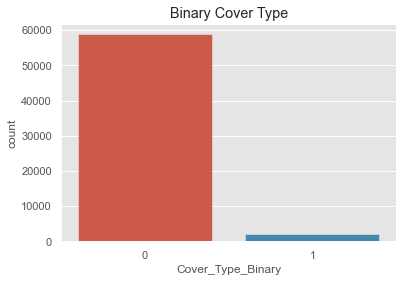

In [201]:
sns.countplot(x = "Cover_Type_Binary", data = df_train)
plt.title("Binary Cover Type")

For the multiclass problem, there is an important number of observations for classes 2 and 1, and a relative low frequency for the other classes.

In [202]:
df_train.Cover_Type_Multiclass.value_counts()

2    29690
1    22199
3     3802
7     2163
6     1865
5      992
4      295
Name: Cover_Type_Multiclass, dtype: int64

Text(0.5, 1.0, 'Multiclass Cover Type')

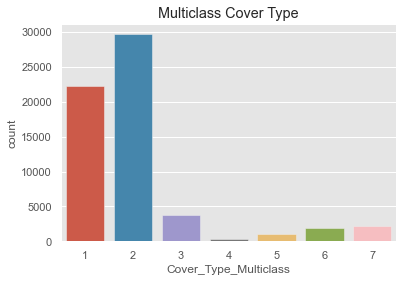

In [203]:
sns.countplot(x = "Cover_Type_Multiclass", data = df_train)
plt.title("Multiclass Cover Type")

## Exploratory Data Analysis 

We first perform EDA to examine the data and the trends that underlie it, but specifically to analyze the relationship between our target variable `Cover_Type` and the other variables. Let's check first which columns are in the datasets, the number of missing values and their types:

In [204]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61006 entries, 0 to 61005
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   Elevation              61006 non-null  int64
 1   Aspect                 61006 non-null  int64
 2   Slope                  61006 non-null  int64
 3   Horiz_dist_hydro       61006 non-null  int64
 4   Vertical_dist_hydro    61006 non-null  int64
 5   Horiz_dist_roadways    61006 non-null  int64
 6   Hillshade_9am          61006 non-null  int64
 7   Hillshade_Noon         61006 non-null  int64
 8   Hillshade_3pm          61006 non-null  int64
 9   Horiz_dist_firepoints  61006 non-null  int64
 10  Cover_Type_Multiclass  61006 non-null  int64
 11  Wilderness_Area        61006 non-null  int64
 12  Soil_Type              61006 non-null  int64
 13  Cover_Type_Binary      61006 non-null  int64
dtypes: int64(14)
memory usage: 6.5 MB


In [205]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13073 entries, 0 to 13072
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   Elevation              13073 non-null  int64
 1   Aspect                 13073 non-null  int64
 2   Slope                  13073 non-null  int64
 3   Horiz_dist_hydro       13073 non-null  int64
 4   Vertical_dist_hydro    13073 non-null  int64
 5   Horiz_dist_roadways    13073 non-null  int64
 6   Hillshade_9am          13073 non-null  int64
 7   Hillshade_Noon         13073 non-null  int64
 8   Hillshade_3pm          13073 non-null  int64
 9   Horiz_dist_firepoints  13073 non-null  int64
 10  Wilderness_Area        13073 non-null  int64
 11  Soil_Type              13073 non-null  int64
dtypes: int64(12)
memory usage: 1.2 MB


As it is possible to see, there are no missing values in the datasets and all variables are numerical, except for `Wilderness_Area` and `Soil_Type`, which are categorical, `Soil_Type` has 39 types, while `Wilderness_Area` has 4 types. 

On the other hand, an easy way to see correlations among the variables is to plot a correlation matrix using a heatmap.

<AxesSubplot:>

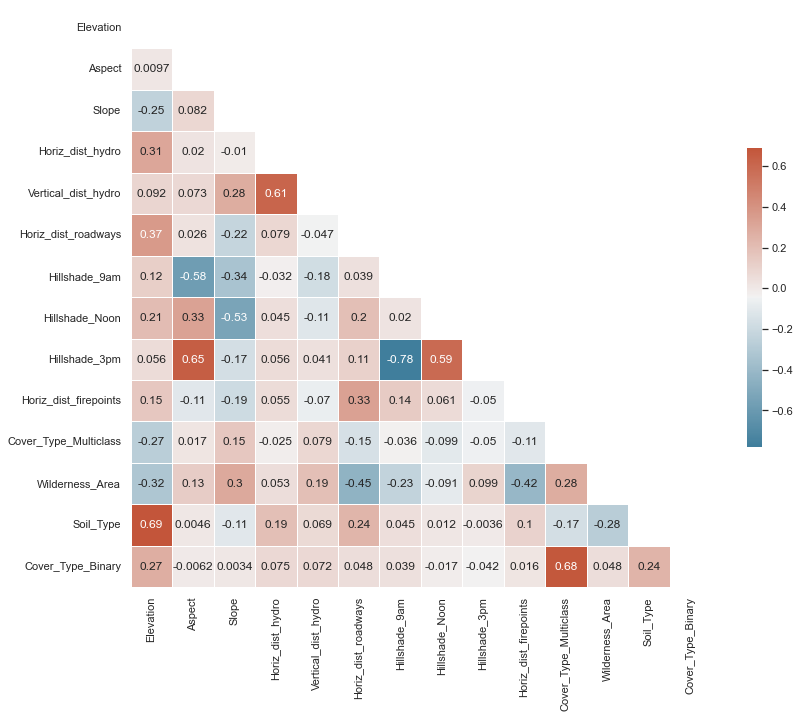

In [206]:
sns.set_theme(style="white")

# Compute the correlation matrix
corr = df_train.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(13, 11))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot =True) 

 In this case, we are able to identify relationships among regressors, but not between the regressors and the outcome variable, as `Cover_Type` is a categorical variable. Note that `Hillshade_3pm` is highly correlated with `Hillshade_9am` and `Hillshade_Noon`. In the same way, there is a high correlation between `Aspect` and the Hillshade variables and between `Vertical_dist_hydro` and `Horizontal_dist_hydro`.

Now, let's perform an EDA to examine the pairwise relationship between `Cover_Type` and each of the other variables. 

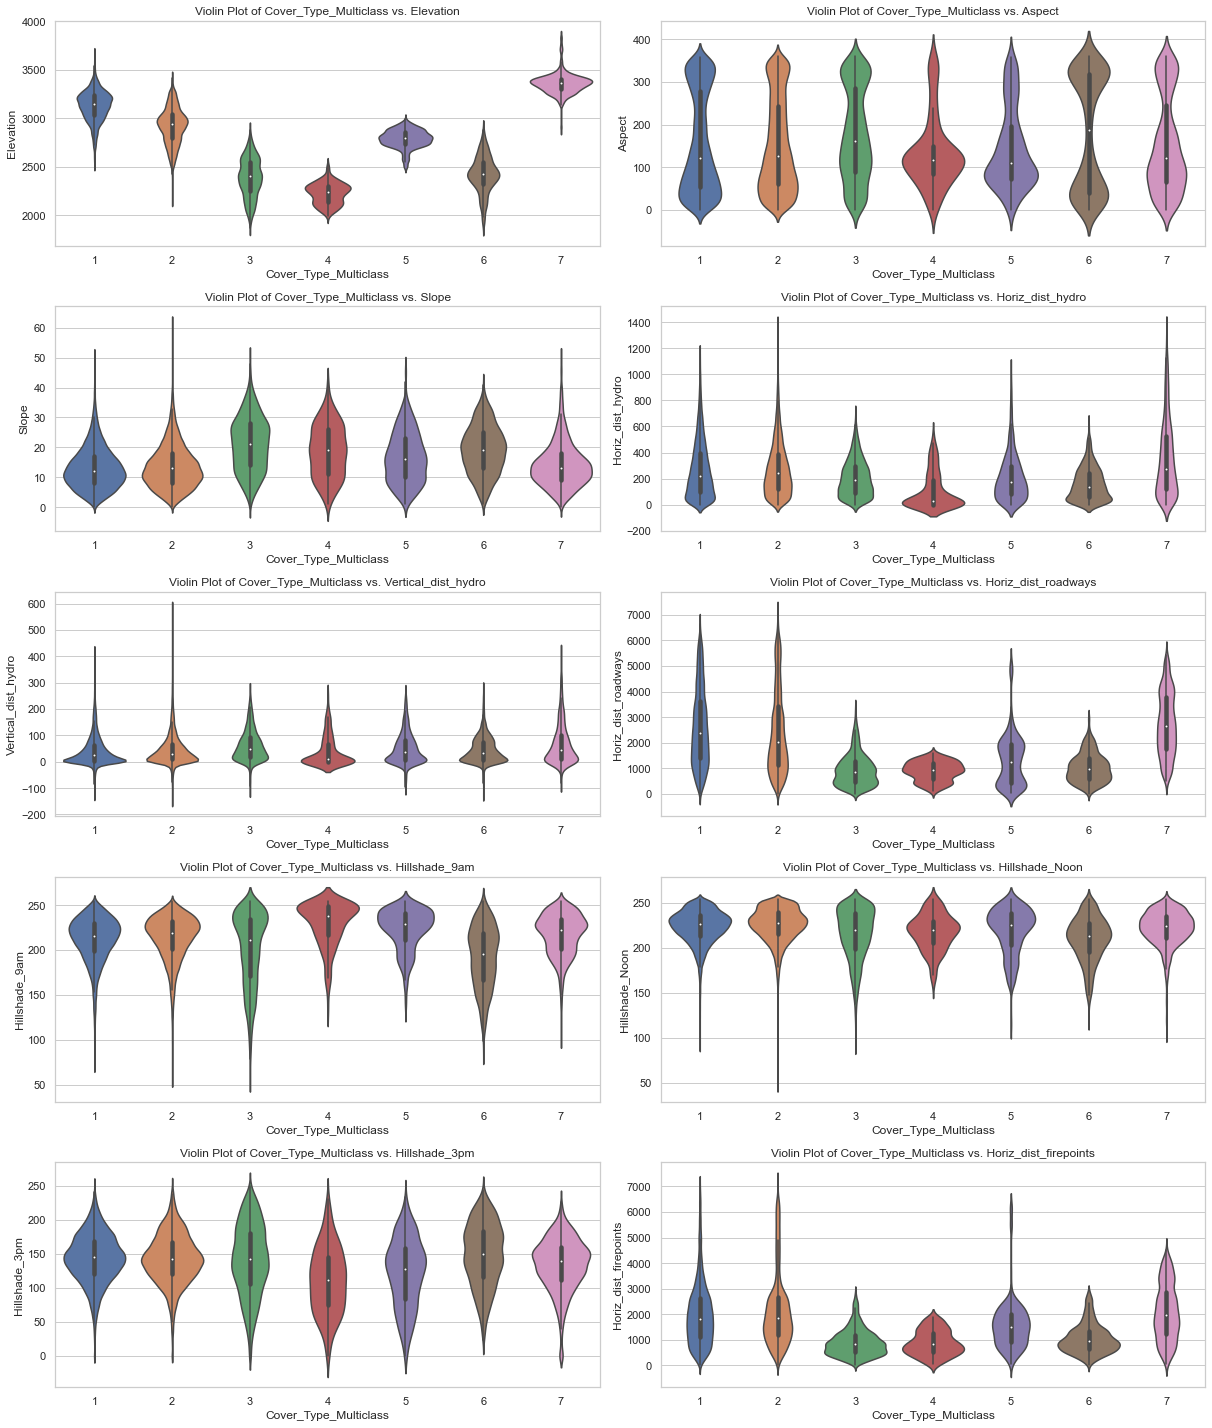

In [212]:
def Mult_Violin_Plot(data, outcome, varlist):
    sns.set_theme(style="whitegrid")
    # Iterate over variables in a list and create scatterplots for numerical variables and violinplots for categorical 
    plt.figure(figsize=(17,20))
    for i, var in enumerate(varlist):
        plt.subplot(5, 2, i+1)
        sns.violinplot(x = outcome, y = var, data = data)
        plt.title("Violin Plot of " +  outcome + " vs. " + var)
        legend_labels, _= ax.get_legend_handles_labels()
    
    return plt.tight_layout()


# Columns for violin plots
cols = ['Elevation','Aspect', 'Slope', 'Horiz_dist_hydro', 'Vertical_dist_hydro', 'Horiz_dist_roadways', 
                             'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horiz_dist_firepoints']

# Violin Plot
Mult_Violin_Plot(df_train, "Cover_Type_Multiclass", cols)

From the plots above, we can note that the difference between the classes of `Cover_Type` in the distribution of the variable `Elevation` is very drastic, which implies that this variable could be relevant for separating the different classes of `Cover_Type`. In the same way, we can see a slight difference in the median of the different classes in the variables `Horiz_dist_roadways` and `Horiz_dist_firepoints`, meaning that these variables could be relevant for predicting the classes. Other variables like `Vertical_dist_hydro` and `Hillshade_Noon` seem to not be relevant for separating `Cover_Type` classes as we do not see a clear change in the distribution acrros Cover Type classes. Likewise, horizontal distance to road and hydrology have similar distribution, as well as, the horizontal distance to roads and wildfire ignition points.

For the binary case, we can identify a similar pattern where `Elevation` is relevant for desagregating `Cover_Type`. Also, notice that the variables Slope, Hillshade Noon and Hillshade 3pm do not generate relevant differences between the distribution of the class 7 and the other classes. 

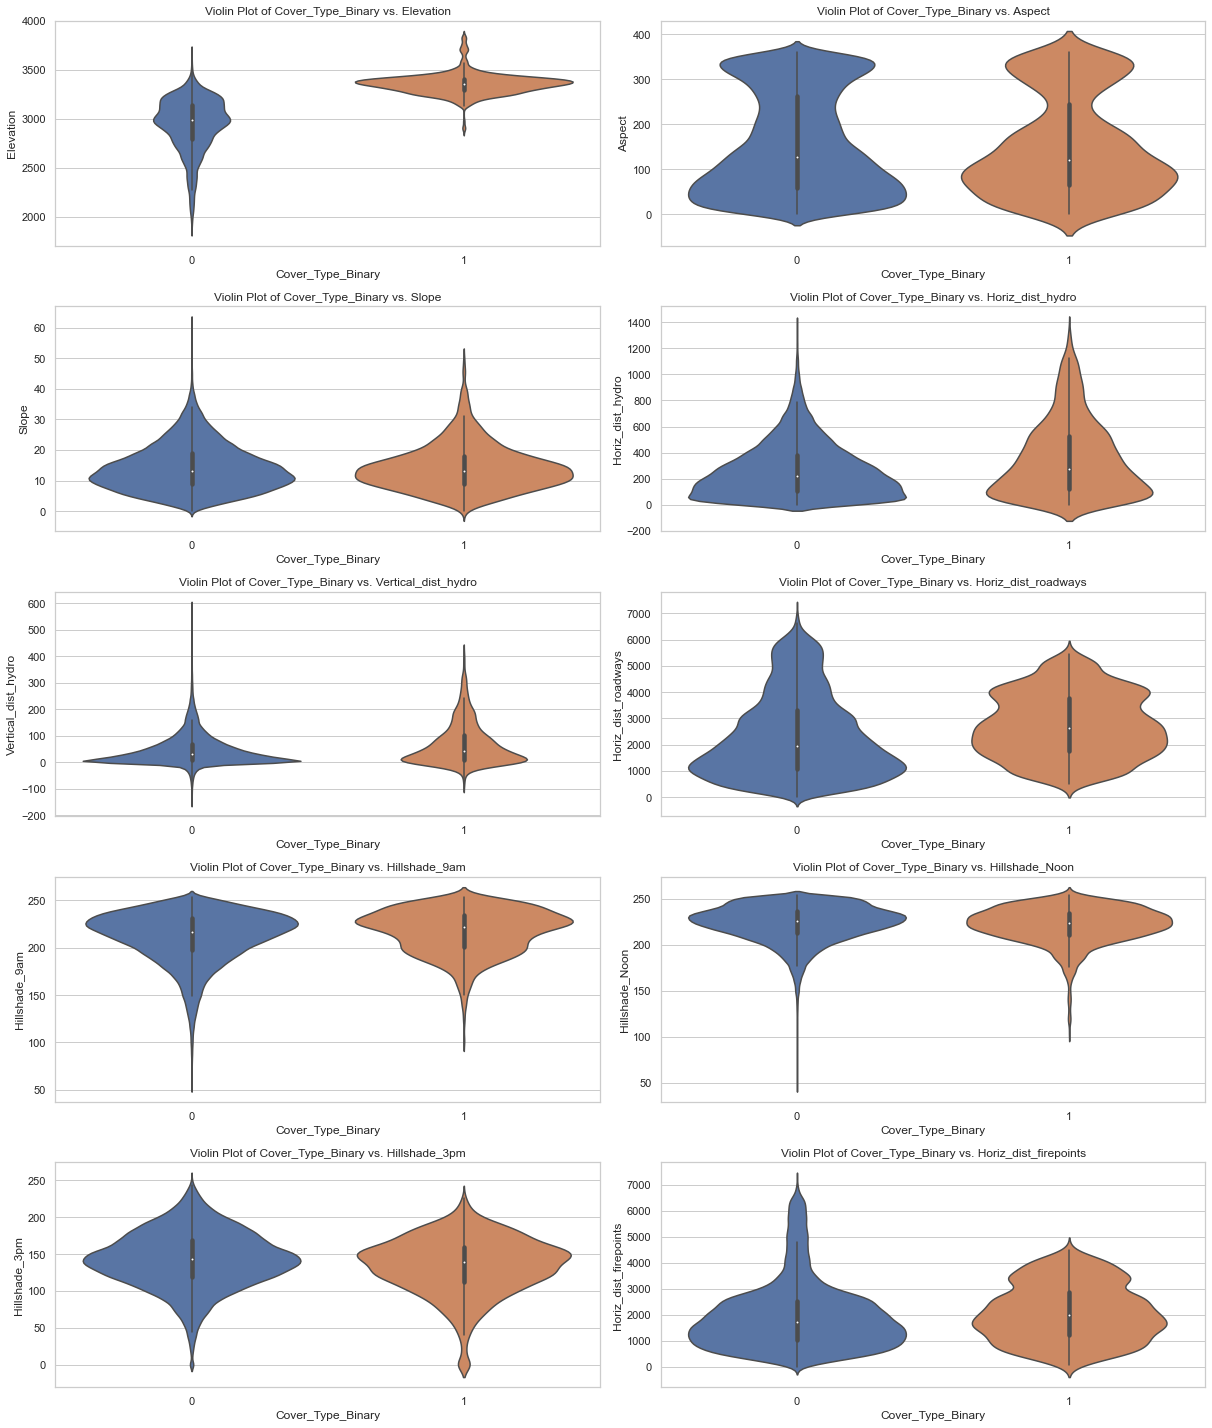

In [213]:
Mult_Violin_Plot(df_train, "Cover_Type_Binary", cols)

In order to check the relationship between the Cover Type and the discrete variables `Wilderness_Area` and `Soil_Type`, we can perform a chi-square test based on a *contingency table* to verify if the observed relationship is statistically significant. 

In [221]:
class Contengency_Table:
    def __init__(self, df, outcome, var):
        self.cont_table = pd.crosstab(df[var], df[outcome], margins=True)
        self._var = var
    def chi_squared_test(self):
        chi2, p, dof, ex = chi2_contingency(self.cont_table)
        print(self._var,': p-value of chisquare test =', p)
    def barplot(self):
        sns.set_theme(style="whitegrid")
        k=pd.melt(ct.cont_table.drop("All", axis=0).reset_index().drop("All", axis = 1), id_vars = [var])
        k[var] = k[var].astype("category")
        return sns.barplot(x=var, y = "value", hue=outcome, data=k)   

Cover_Type_Binary,0,1,All
Wilderness_Area,,,
1,26878,554,27432
2,2897,228,3125
3,25131,1381,26512
4,3937,0,3937
All,58843,2163,61006


Wilderness_Area : p-value of chisquare test = 2.1518652297647443e-140


<AxesSubplot:xlabel='Wilderness_Area', ylabel='value'>

Cover_Type_Binary,0,1,All
Soil_Type,,,
1,346,0,346
2,802,0,802
3,507,0,507
4,1288,11,1299
5,172,0,172
6,695,0,695
7,12,0,12
8,21,0,21
9,104,0,104


Soil_Type : p-value of chisquare test = 0.0


<AxesSubplot:xlabel='Soil_Type', ylabel='value'>

Cover_Type_Multiclass,1,2,3,4,5,6,7,All
Wilderness_Area,,,,,,,,
1,11152,15330,0,0,396,0,554,27432
2,1971,926,0,0,0,0,228,3125
3,9076,13127,1499,0,596,833,1381,26512
4,0,307,2303,295,0,1032,0,3937
All,22199,29690,3802,295,992,1865,2163,61006


Wilderness_Area : p-value of chisquare test = 0.0


<AxesSubplot:xlabel='Wilderness_Area', ylabel='value'>

Cover_Type_Multiclass,1,2,3,4,5,6,7,All
Soil_Type,,,,,,,,
1,0,0,243,17,0,86,0,346
2,0,101,539,10,28,124,0,802
3,0,128,246,109,0,24,0,507
4,18,343,788,16,57,66,11,1299
5,0,0,105,6,0,61,0,172
6,0,84,415,43,0,153,0,695
7,0,12,0,0,0,0,0,12
8,4,17,0,0,0,0,0,21
9,18,86,0,0,0,0,0,104


Soil_Type : p-value of chisquare test = 0.0


<AxesSubplot:xlabel='Soil_Type', ylabel='value'>

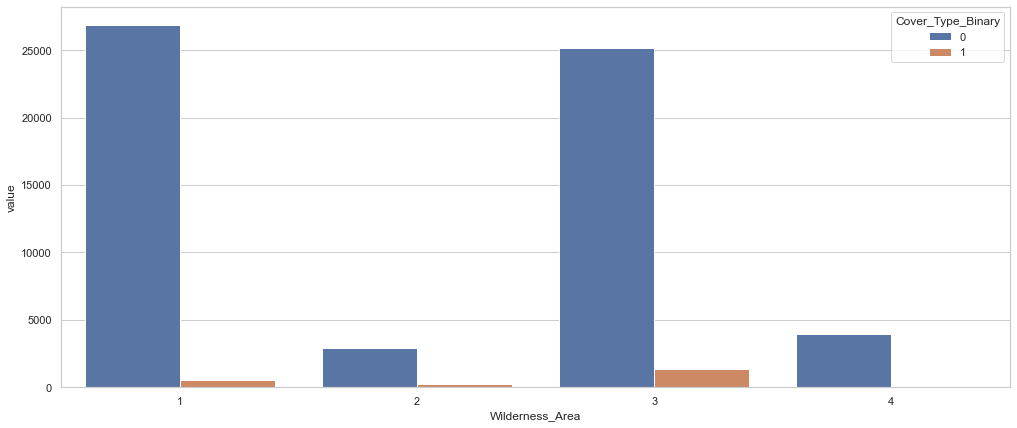

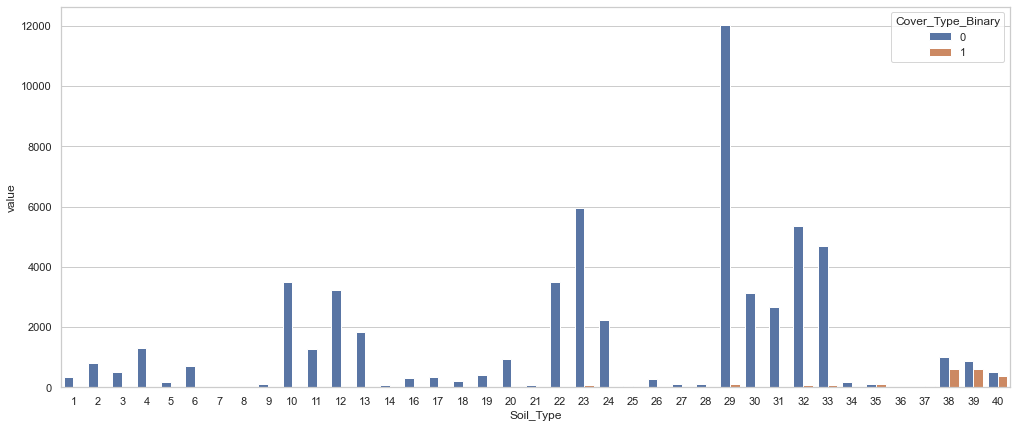

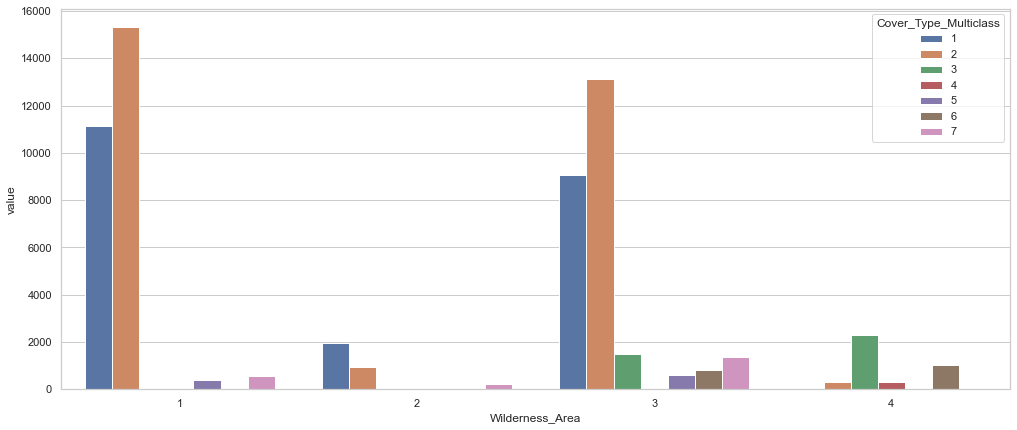

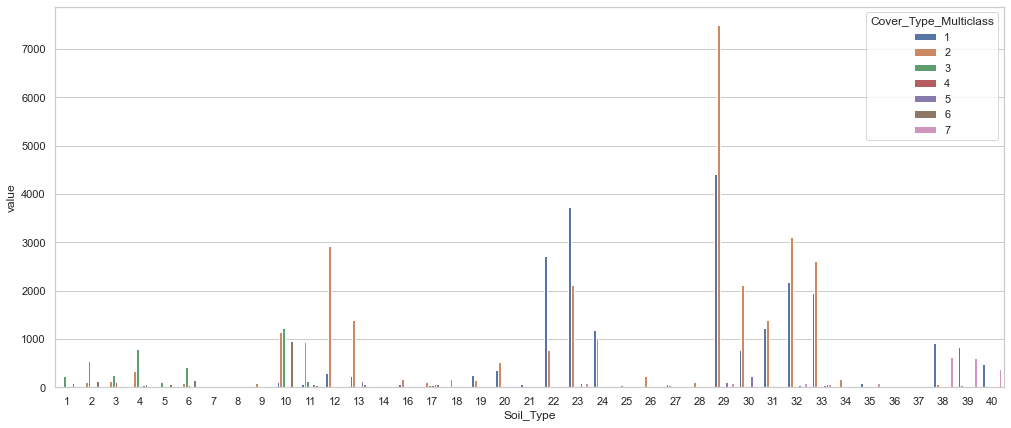

In [222]:
for outcome in ["Cover_Type_Binary", "Cover_Type_Multiclass"]:
    for var in ["Wilderness_Area",  "Soil_Type"]:
        ct = Contengency_Table(df_train, outcome, var)
        display(ct.cont_table)
        ct.chi_squared_test()
        plt.figure(figsize=(17,7))
        display(ct.barplot())

The chi-square test verifies that the associations between the Cover Type variables (Binary and Multiclass) and `Wilderness_Area` and `Soil_Type` are indeed statistically significant. On the other hand, from the tables and the bar plots, it it possible to see that practically all the Cover Type class 4 observations have category 4 in Wilderness Area, this is a good class distinction. Similarly, Soil Type 1-6,10-14,17, 22-23, 29-33,35,38-40 offer lot of class distinction as counts for some are very high. For the binary case, it is important to highlight that there are only an important number of observations of class 1 in Soil Type 35,38,39 and 40.

## Features Transformation

**Dummy Creation**

Since `Wilderness_Area` and `Soil_Type` are categorical variables it is important to convert them into dummy variables, for doing this, we need to apply the *One-Hot-Encoding* method. For the standardization, we will only standardize the continuous variables, but noy the dummy variables. Therefore, for creating the standardized matrix of regressors (`X_sc_train` and `X_sc_test`), we separate our features into two sets, one continuous (which will be standardize) and one discrete (for categorical), and then we merge them.

In [20]:
# List with categorical variables
catvar = ["Wilderness_Area", "Soil_Type"]

# Outcomes variables
Cover_Type_Multiclass = df_train.Cover_Type_Multiclass
Cover_Type_Binary = df_train.Cover_Type_Binary

#----- For training set ------

# Generate X regressors matrices without scaling
X_train = df_train.drop(["Cover_Type_Multiclass", "Cover_Type_Binary"], axis = 1)  # Drop outcome variables
X_train = pd.get_dummies(X_train, columns = catvar, drop_first=1)                  # Create dummy variables

# X with continuous variables and keep column names
X_train_cont = df_train.drop(["Wilderness_Area", "Soil_Type", "Cover_Type_Multiclass", "Cover_Type_Binary"], axis = 1)
cont_names = X_train_cont.columns

# X with dummy variables and keep column names
X_train_cat = pd.get_dummies(df_train[catvar], columns = catvar, drop_first=True)
dummy_names = X_train_cat.columns


#----- For testing set ----

# X with continuous variables and keep column names
X_test_cont = df_test.drop(["Wilderness_Area", "Soil_Type"], axis = 1)

# X with dummy variables and keep column names
X_test_cat = pd.get_dummies(df_test[catvar], columns = catvar, drop_first=True)

**Standardization**

In [21]:
from sklearn.preprocessing import StandardScaler

# Instantiate StandardScaler()
scl = StandardScaler()

# Fit scaler with data of continuous variables
scl.fit(X_train_cont)

# Standardize training set continuous variables
X_train_cont = scl.transform(X_train_cont)

# Standardize testing set continuous variables
X_test_cont = scl.transform(X_test_cont)

# Concatenate with dummy variables data 
X_sc_train = pd.DataFrame(np.concatenate((X_train_cont,X_train_cat),axis=1))  # Training set
X_sc_test = pd.DataFrame(np.concatenate((X_test_cont,X_test_cat),axis=1))     # Testing set

# Put again column names
column_names = cont_names.to_list() + dummy_names.to_list()
X_sc_train.columns = column_names
X_sc_test.columns = column_names

# Display results
display(X_sc_train)
display(X_sc_test)

,Elevation,Aspect,Slope,Horiz_dist_hydro,Vertical_dist_hydro,Horiz_dist_roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horiz_dist_firepoints,...,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Soil_Type_40
0,0.869608,-1.089548,-0.549948,-1.267979,-0.798254,0.262324,0.262693,-0.259695,-0.224995,-0.186425,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.552827,0.844259,-0.152141,-0.362494,-0.113321,2.082645,-0.773196,1.297340,1.364189,0.436970,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.557684,-0.706351,-0.682551,1.137217,-0.507158,-0.399145,0.743641,-0.008560,-0.537621,-0.677700,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.737912,-0.661793,-0.682551,0.236447,0.160652,1.627565,0.780637,0.091894,-0.485516,-0.400551,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.321471,1.575006,-0.417346,-0.683187,-0.267431,0.302704,-0.588216,0.142121,0.712884,-0.997370,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61001,1.058252,-1.383629,-0.152141,-1.267979,-0.798254,-0.511953,-0.403236,-0.410375,0.217893,-0.961682,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
61002,0.755709,0.122423,1.439088,0.698623,0.246268,0.162976,0.632653,0.895525,-0.381308,1.040623,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
61003,0.129267,0.122423,-0.152141,-0.636026,-0.490034,-0.474778,0.632653,1.096433,0.087632,0.314721,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
61004,-1.475991,-0.189481,-1.345563,-0.683187,-0.507158,-1.170858,0.558661,0.744844,0.061580,-0.663273,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,Elevation,Aspect,Slope,Horiz_dist_hydro,Vertical_dist_hydro,Horiz_dist_roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horiz_dist_firepoints,...,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Soil_Type_40
0,0.545709,-0.750909,-0.152141,0.066669,0.503118,-1.102917,0.854629,-0.460602,-0.876299,-1.124175,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.675142,-1.392540,0.776076,-0.636026,-0.353048,-0.922167,-0.958176,-1.264233,0.087632,-0.004190,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.431982,1.031401,-0.152141,1.962530,2.249696,1.378873,-0.995172,1.046206,1.442346,0.503030,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-1.938704,-1.392540,-1.478165,-0.320049,-0.490034,-1.147784,0.114709,0.493709,0.348154,-0.845508,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.507853,-0.911317,-0.417346,-1.069904,-0.644144,-0.024184,0.521665,-0.309922,-0.511569,0.673116,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13068,0.339267,0.220450,-0.284743,-0.560569,-1.020857,-0.120969,0.447673,1.247114,0.322102,1.402814,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13069,-0.062937,0.550178,1.704293,-1.126497,-0.729761,-0.588227,-1.217148,1.498248,1.416294,0.483288,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13070,0.200454,0.461062,-1.345563,0.066669,-0.164691,1.516038,0.188701,0.995979,0.504467,-1.421066,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13071,-0.433107,-1.294513,-0.019538,-0.051233,-0.096198,0.635362,-0.292248,-0.661510,-0.042629,-0.668588,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Adding polynomials

We will add to our variables polynomials of second degree to some of the models that we will run. Therefore we create the numpy arrays `X_scl_train_poly` and `X_scl_test_poly`.

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2)
X_scl_train_poly = poly.fit_transform(X_sc_train)
X_scl_test_poly=poly.fit_transform(X_sc_test)

# Modelling 

## Binary Model

As we have an imbalance problem, then it is necessary to include the argument `class_weight = 'balanced'` in our LogisticRegression model. 

### Model 1

In [231]:
from sklearn.linear_model import LogisticRegression

model1 = LogisticRegression(C=100, class_weight='balanced', solver='liblinear')
model1.fit(X_sc_train, Cover_Type_Binary)
y_prob_imb = model1.predict_proba(X_sc_train)
df_train["pred_prob_imb_m1"] = y_prob_imb[:,1]

Note that these are not proper estimates of the class probability: we need to correct for the biased sample by rescaling the predicted probability. This happens since the predicted probabilities are larger than the real ones, as we have a unbalanced sample. Therefore the probabilities estimated by the model should be changed to:

$$w = \frac{\pi(y_i)\frac{q(y_i)}{r(y_i)}}{\pi(1)\frac{q(1)}{r(1)}+\pi(0)\frac{q(0)}{r(0)}}$$

Where $\pi(y_i)$ are the biased probabilities, $q(1)$ and $q(0)$ are the probabilities of the two classes in the population of interest and $r(y)$ are the probabilities with which we have sampled. For doing the reweighting, we apply the function `reweight`.

In [ ]:
# Rescaling probabilities (Correction)
q1 = Cover_Type_Binary.sum()/len(Cover_Type_Binary)
r1 = 0.5
df_train["pred_prob_imb_corr_m1"] = df_train["pred_prob_imb_m1"].apply(reweight,args=(q1,r1))

# Predict the classes using the reweighted probabilities
y_pred_new = [1 if pi >= 0.25 else 0 for pi in df_train["pred_prob_imb_corr_m1"]]

Let's see how is performing our predictions, when we have not reweighted the probabilities. 

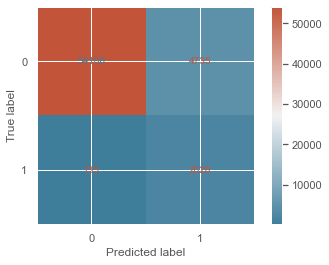

In [87]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model1, X_sc_train, Cover_Type_Binary, cmap = sns.diverging_palette(230, 20, as_cmap=True))

In [75]:
from sklearn.metrics import accuracy_score
accuracy_score(Cover_Type_Binary, model1.predict(X_sc_train))

0.9201717863816674

Note that the accuracy without taking into account the reweighted probabilities is about 92%, while using the reweighted ones it is obtained the following score: 

In [76]:
accuracy_score(Cover_Type_Binary, y_pred_new)

0.9693308854866735

The accuracy improves with the reweighted probabilities, this happens because the predicted probabilities are larger than the real ones. The Confussion Matrix with the prediction did with reweighted probabilities is: 

In [223]:

def plot_cf_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
    

Confusion matrix, without normalization
[[58044   799]
 [  292  1871]]


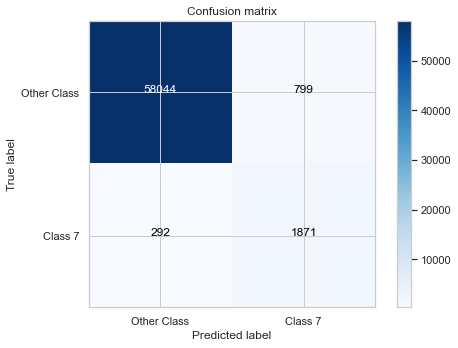

In [224]:
f, ax = plt.subplots(figsize=(7, 5))
cm =  confusion_matrix(y_pred=y_pred_new, y_true=Cover_Type_Binary, labels=[0,1])
# Plotting confusion matrix (custom help function)
plot_cf_matrix(cm, ["Other Class", "Class 7"])

Amother metric very useful for know how well is doing the classifier is the ROC curve and AUC. The AUC is the measure of the ability of a classifier to distinguish between classes and is used as a summary of the ROC curve.

In [225]:
import matplotlib.pyplot as plt 
from sklearn.metrics import roc_curve, auc

def roc_auc_plot(pred_probs, y_true):
    sns.set_theme(style="whitegrid")
    fpr, tpr, _ = roc_curve(y_true, pred_probs)  #compute FPR/TPR
    auc_baseline = auc(fpr, tpr) # compute AUC
    plt.subplots(figsize=(10, 6))
    plt.plot(fpr, tpr, "b-", label="ROC Curve (AUC={:2.2f})".format(auc_baseline))
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(fontsize=15)
    plt.plot([0,1], [0,1], "r--")
    plt.title("ROC curve")

In [ ]:
roc_auc_plot(pred_probs=df_train["pred_prob_imb_corr_m1"], y_true=Cover_Type_Binary)

The in-sample AUC is 0.98, which implies that there is a 98% chance that the model will be able to distingish between the Cover Type class 7 and the other classes. Now, we are going to predict the probabilities of being cover type class 7 for the testing dataset and afterwards we will reweight the probabilities. 

In [101]:
# Testing set 
probas_test_model1 = model1.predict_proba(X_sc_test)

In [102]:
probas_test_rew_model1 = np.array(pd.Series(probas_test_model1[:,1]).apply(reweight,args=(q1,r1))) # Kaggle predictions

### Cross-Validation

In order to asses the model performance on held out data we can use a method called *Cross-Validation*. This method is sometimes computationally expensive, as it has to 'fit' the model many times. That is why instead of using the function `GridSearchCV`, we will use `RandomizedSearchCV`. This method is less computationally expensive as it randomized searchs on hyperparameters. In contrast to `GridSearchCV`, not all parameter values are tried out, but rather a fixed number of parameter settings is sampled from the specified distributions.

In [110]:
from sklearn.model_selection import RandomizedSearchCV
model_1_cv = LogisticRegression(solver='saga', tol=1e-2, max_iter=200, random_state=0)
distributions = dict(C= [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 10, 50, 100, 1000], penalty=['l2', 'l1'])
clf = RandomizedSearchCV(model_1_cv, distributions, random_state=0)
search = clf.fit(X_sc_train, Cover_Type_Binary)
search.best_params_

{'penalty': 'l1', 'C': 0.6}

In [112]:
search.best_score_

0.9773792633982875

Now we will run a model with this tuned parameters: 


In [114]:
model1_cv = LogisticRegression(C=0.6, class_weight='balanced', solver='liblinear', penalty = 'l1')
model1_cv.fit(X_sc_train, Cover_Type_Binary)
y_prob_imb_cv = model1_cv.predict_proba(X_sc_train)
df_train["pred_prob_imb_m1_c"] = y_prob_imb_cv[:,1]
df_train["pred_prob_imb_corr_m1_c"] = df_train["pred_prob_imb_m1_c"].apply(reweight,args=(q1,r1))

In [129]:
# Predict for testing set 
predictions_m1_cv = model1_cv.predict_proba(X_sc_test)[:,1]
# Reweight probabilities
predictions_m1_cv = np.apply_along_axis(reweight, 0, predictions_m1_cv)

In [130]:
predictions_m1_cv

array([4.46768695e-02, 1.71935781e-04, 9.61608970e-01, ...,
       2.98562022e-03, 6.40074375e-05, 8.74083871e-01])

Submit to Kaggle: 

In [131]:
# Step 9: Produce .csv for kaggle testing 
test_predictions_submit =  pd.DataFrame({"Index": index_test, "Cover_Type": predictions_m1_cv})
test_predictions_submit.to_csv("test_LogReg_predictions_submit (Model 1 - CV).csv", index = False)

In [132]:
test_predictions_submit

,Index,Cover_Type
0,61006,4.467687e-02
1,61007,1.719358e-04
2,61008,9.616090e-01
3,61009,8.386992e-08
4,61010,5.149851e-04
...,...,...
13068,74074,2.915946e-02
13069,74075,7.198174e-03
13070,74076,2.985620e-03
13071,74077,6.400744e-05


### Model 2 

In this model we will include some polynomial features transformation. Based on the results of the last *Cross-Validation*, we will try to first the model with a small hyperparameter *C*.

In [133]:
model1_poly = LogisticRegression(C=0.01, class_weight='balanced', solver='liblinear')
model1_poly.fit(X_scl_train_poly, Cover_Type_Binary)
y_prob_imb = model1_poly.predict_proba(X_scl_train_poly)
df_train["pred_prob_imb_m2"] = y_prob_imb[:,1]

In [136]:
df_train["pred_prob_imb_corr_m2"] = df_train["pred_prob_imb_m2"].apply(reweight,args=(q1,r1))

# Predict the classes using the reweighted probabilities
y_pred_new = [1 if pi >= 0.25 else 0 for pi in df_train["pred_prob_imb_corr_m2"]]

In [137]:
# Check accuracy
accuracy_score(Cover_Type_Binary, model1_poly.predict(X_scl_train_poly))

0.9453332459102384

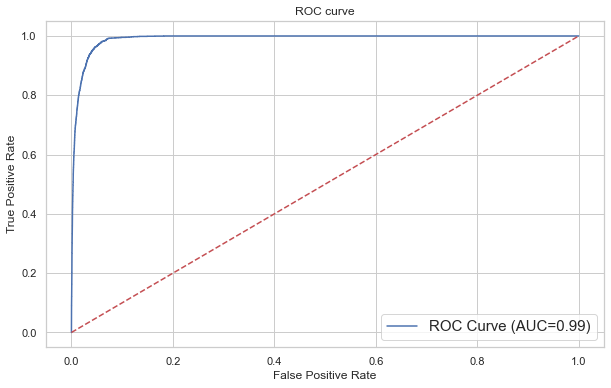

In [138]:
# Check AUC
roc_auc_plot(pred_probs=df_train["pred_prob_imb_corr_m2"], y_true=Cover_Type_Binary)

In [139]:
# Testing set 
probas_test_model1 = model1_poly.predict_proba(X_scl_test_poly)

In [140]:
probas_test_rew_model1 = np.array(pd.Series(probas_test_model1[:,1]).apply(reweight,args=(q1,r1))) # Kaggle predictions

In [142]:
# Step 9: Produce .csv for kaggle testing 
test_predictions_submit =  pd.DataFrame({"Index": index_test, "Cover_Type": probas_test_rew_model1})
test_predictions_submit.to_csv("test_LogReg_predictions_submit Binary (Model 2 - Poly).csv", index = False)

**Cross-Validation:**


In [149]:
model_2_cv = LogisticRegression(class_weight='balanced', solver='liblinear')
distributions = dict(C= np.linspace(0, 1, 50), penalty=['l2', 'l1'])
clf = RandomizedSearchCV(model_2_cv, distributions, random_state=0)
search = clf.fit(X_scl_train_poly, Cover_Type_Binary)
search.best_params_

{'penalty': 'l1', 'C': 0.9591836734693877}

In [150]:
model1_poly_cv = LogisticRegression(C=0.9591836734693877, class_weight='balanced', solver='liblinear', penalty = 'l1')
model1_poly_cv.fit(X_scl_train_poly, Cover_Type_Binary)
y_prob_imb = model1_poly_cv.predict_proba(X_scl_train_poly)
df_train["pred_prob_imb_m2_cv"] = y_prob_imb[:,1]

In [151]:
df_train["pred_prob_imb_corr_m2_cv"] = df_train["pred_prob_imb_m2_cv"].apply(reweight,args=(q1,r1))
# Predict the classes using the reweighted probabilities
y_pred_new = [1 if pi >= 0.25 else 0 for pi in df_train["pred_prob_imb_corr_m2_cv"]]

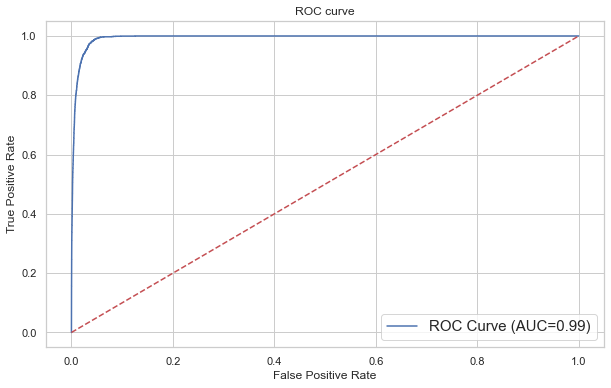

In [152]:
roc_auc_plot(pred_probs=df_train["pred_prob_imb_corr_m2_cv"], y_true=Cover_Type_Binary)

In [153]:
# Testing set 
probas_test_model1_cv = model1_poly_cv.predict_proba(X_scl_test_poly)

probas_test_rew_model1_cv = np.array(pd.Series(probas_test_model1_cv[:,1]).apply(reweight,args=(q1,r1))) # Kaggle predictions

In [154]:
# Step 9: Produce .csv for kaggle testing 
test_predictions_submit =  pd.DataFrame({"Index": index_test, "Cover_Type": probas_test_rew_model1_cv})
test_predictions_submit.to_csv("test_LogReg_predictions_submit Binary (Model 2 - Poly (CV)).csv", index = False)

## Multiclass Model

In the Multiclass classification problem we will train 2 models, one without polynomial features and other one with polynomial features of second degree. The predicted probabilities are reweighted in order to correct for the imbalanced problem present in the training data. In this way, the probabilities estimated by the model should be changed to:

$$w = \frac{\pi(y_i)\frac{q(y_i)}{r(y_i)}}{\sum_{j = 1}^7 \pi(y_j) \frac{q(y_j)}{r(y_j)}}$$

In [32]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2)
X_scl_train_poly = poly.fit_transform(X_sc_train)
X_scl_test_poly=poly.fit_transform(X_sc_test)

In [33]:
model_m = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, 
                             fit_intercept=True, intercept_scaling=1, solver='saga', max_iter=1000, 
                             multi_class='multinomial', verbose=0, warm_start=False,
                             class_weight='balanced')
model_m.fit(X_sc_train, Cover_Type_Multiclass)

LogisticRegression(class_weight='balanced', max_iter=1000,
                   multi_class='multinomial', solver='saga')

In [34]:
predictions = model_m.predict(X_sc_test)
predictions_proba_imb = model_m.predict(X_sc_test)

In [42]:
prob_predict = model_m.predict_proba(X_sc_test)

In [44]:
rw = reweight_multiclass(Cover_Type_Multiclass, prob_predict, 1/7)

In [50]:
final_predictions = []
for row in rw: 
    prediction = row.argmax()+1
    final_predictions.append(prediction)
    
final_predictions = np.array(final_predictions)

**Cross-Validation:**

The following *Cross-Validation* takes hours to run, however the results of the tuned parameters are used for running the *MultiClass Model with tuned parameters* which is presented in the next section: 

In [ ]:
model_1_cv_multi = LogisticRegression(class_weight='balanced', multi_class = "multinomial", solver='saga')
distributions = dict(C= [0.0001, 0.01, 0.1,  0.5, 1, 10, 100, 1000], penalty=['l2', 'l1'])
clf = RandomizedSearchCV(model_1_cv_multi, distributions, random_state=0)
search = clf.fit(X_scl_train_poly, Cover_Type_Multiclass)

### MultiClass Model with tuned parameters

In [ ]:
model_m = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, 
                             fit_intercept=True, intercept_scaling=1, solver='saga', max_iter=1000, 
                             multi_class='multinomial', verbose=0, warm_start=False,
                             class_weight='balanced')
model_m.fit(X_scl_train_poly, Cover_Type_Multiclass)

In [164]:
y_prob_imb_train = model_m.predict_proba(X_scl_train_poly)

**Reweighting**

In [167]:
rw = reweight_multiclass(Cover_Type_Multiclass, y_prob_imb_train, 1/7)

In [168]:
rw

array([[7.80273279e-01, 3.60172251e-02, 9.88876692e-06, ...,
        5.55755471e-09, 3.38275371e-07, 1.83699261e-01],
       [4.32410869e-01, 5.66468735e-01, 1.19337148e-08, ...,
        9.95421629e-07, 2.72758310e-07, 1.11911593e-03],
       [3.80539670e-02, 9.61847424e-01, 3.41599423e-05, ...,
        5.46870993e-05, 5.47682981e-06, 4.27604196e-06],
       ...,
       [2.22342022e-01, 7.65943677e-01, 3.88031201e-05, ...,
        1.16483251e-02, 3.98593093e-06, 2.31844469e-05],
       [6.14623004e-03, 3.30124975e-01, 4.90415642e-01, ...,
        1.01501900e-04, 1.51711492e-01, 2.04049570e-05],
       [2.62693606e-02, 8.11278616e-01, 1.80020361e-02, ...,
        8.38386553e-02, 6.06107708e-02, 4.64165298e-07]])

In [169]:
predictions_train = []
for row in rw: 
    prediction = row.argmax()+1
    predictions_train.append(prediction)
    
predictions_train = np.array(predictions_train)
predictions_train

array([1, 2, 2, ..., 2, 3, 2], dtype=int64)

**Confussion matrix for training set**

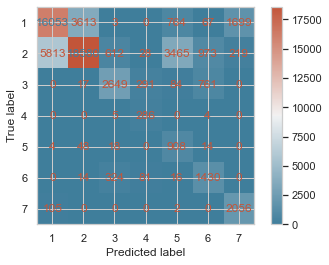

In [171]:
plot_confusion_matrix(model_m, X_scl_train_poly, Cover_Type_Multiclass, cmap = sns.diverging_palette(230, 20, as_cmap=True))

In [158]:
y_prob_imb = model_m.predict_proba(X_scl_test_poly)

In [159]:
y_prob_imb

array([[7.45182593e-01, 2.46394042e-01, 2.09567693e-05, ...,
        6.69300029e-05, 9.09721286e-06, 8.32637301e-03],
       [8.77590837e-02, 4.05085580e-01, 6.55164409e-03, ...,
        4.22483395e-01, 7.80997913e-02, 1.54402161e-05],
       [1.62204739e-01, 1.24286040e-03, 3.99421397e-09, ...,
        5.47183008e-12, 5.82750508e-09, 8.36552391e-01],
       ...,
       [2.83026175e-01, 6.35298474e-01, 2.33346414e-06, ...,
        8.16542699e-02, 8.35900039e-07, 1.79095732e-05],
       [9.73086108e-02, 3.81325987e-01, 2.47854505e-02, ...,
        4.84494035e-01, 1.20386983e-02, 4.71959854e-05],
       [9.45483589e-01, 6.95059676e-04, 6.47635840e-12, ...,
        2.96306042e-13, 1.15357099e-14, 5.21257205e-02]])

**Reweighting probabilities for testing set**

In [160]:
rw = reweight_multiclass(Cover_Type_Multiclass, y_prob_imb, 1/7)

In [161]:
final_predictions = []
for row in rw: 
    prediction = row.argmax()+1
    final_predictions.append(prediction)
    
final_predictions = np.array(final_predictions)

In [162]:
final_predictions

array([1, 2, 1, ..., 2, 2, 1], dtype=int64)

### Kaggle Predictions Submissions

Once you have produced testset predictions you can submit these to <i> kaggle </i> in order to see how your model performs. 

The following code provides an example of generating a <i> .csv </i> file to submit to kaggle
1) create a pandas dataframe with two columns, one with the test set "Index"'s and the other with your probability of the "Covert_Type" being class 7

2) use the <i> .to_csv </i> pandas method to create a csv file. The <i> index = False </i> is important to ensure the <i> .csv </i> is in the format kaggle expects 

In [62]:
# Step 9: Produce .csv for kaggle testing 
test_predictions_submit =  pd.DataFrame({"Index": index_test, "Cover_Type": final_predictions})
test_predictions_submit.to_csv("test_LogReg_predictions_submit (Model 4 - Multi).csv", index = False)